# ANN Classification of 4 class SMR dataset from BCI Competition VI dataset 2a

In [6]:
import mne
%matplotlib inline
import numpy as np

# Mention the file path to the dataset
filename = "./BCICIV_2a_gdf/A01T.gdf"

raw = mne.io.read_raw_edf(filename)

print(raw.info)
print(raw.ch_names)

Extracting EDF parameters from ./BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Overlapping events detected. Use find_edf_events for the original events.
Setting channel info structure...
Interpolating stim channel. Events may jitter.
Creating raw.info structure...
Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, ...
    chs : list | 26 items (EEG: 25, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.5 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : int | 1105963200
    nchan : int | 26
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    

C:\Anaconda3\lib\site-packages\mne-0.16.1-py3.6.egg\mne\io\edf\edf.py:1028: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-6-74dc835d69eb>:8: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw = mne.io.read_raw_edf(filename)
<ipython-input-6-74dc835d69eb>:8: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw = mne.io.read_raw_edf(filename)
<ipython-input-6-74dc835d69eb>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(filename)


## Events and Epoch Extraction

In [4]:
# Find the events time positions
events, _ = mne.events_from_annotations(raw)

# Pre-load the data

raw.load_data()

# Filter the raw signal with a band pass filter in 7-35 Hz

raw.filter(7., 35., fir_design='firwin')

# Remove the EOG channels and pick only desired EEG channels

raw.info['bads'] += ['EOG-left', 'EOG-central', 'EOG-right']

picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False,
                       exclude='bads')

# Extracts epochs of 3s time period from the datset into 288 events for all 4 classes

tmin, tmax = 1., 4.
# left_hand = 769,right_hand = 770,foot = 771,tongue = 772
event_id = dict({'769': 7,'770': 8,'771': 9,'772': 10})

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
Setting up band-pass filter from 7 - 35 Hz
l_trans_bandwidth chosen to be 2.0 Hz
h_trans_bandwidth chosen to be 8.8 Hz
Filter length of 413 samples (1.652 sec) selected
288 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 288 events and 751 original time points ...
0 bad epochs dropped


### Epoch Average

<Evoked  |  'left_hand' (mean, N=72), [1, 4] sec, 22 ch, ~174 kB>


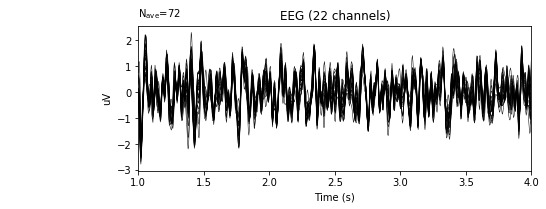

<Evoked  |  'right_hand' (mean, N=72), [1, 4] sec, 22 ch, ~174 kB>


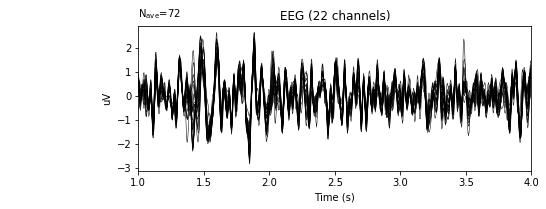

<Evoked  |  'foot' (mean, N=72), [1, 4] sec, 22 ch, ~174 kB>


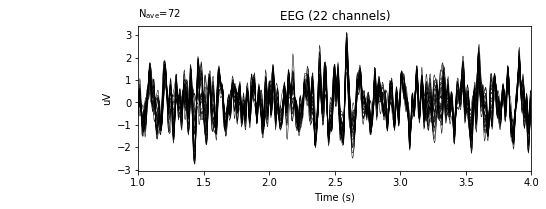

<Evoked  |  'tongue' (mean, N=72), [1, 4] sec, 22 ch, ~174 kB>


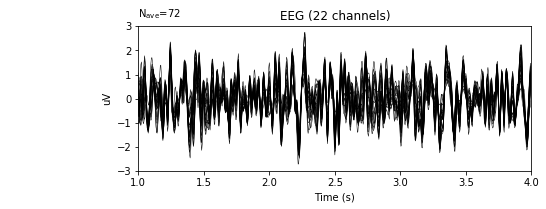

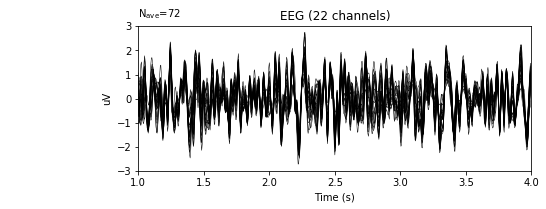

In [11]:
# left_hand = 769,right_hand = 770,foot = 771,tongue = 772

# Left hand epoch average plot

evoked = epochs['769'].average()
print(evoked)
evoked.plot(time_unit='s')

# Right hand epoch average plot

evoked = epochs['770'].average()
print(evoked)
evoked.plot(time_unit='s')

# Foot epoch average plot

evoked = epochs['771'].average()
print(evoked)
evoked.plot(time_unit='s')

# Tongue epoch average plot

evoked = epochs['772'].average()
print(evoked)
evoked.plot(time_unit='s')

## Labels and Data

In [12]:
# Getting labels and changing labels from 7,8,9,10 -> 1,2,3,4
labels = epochs.events[:,-1] - 7 + 1 

data = epochs.get_data()

## Wavelet Packet Decomposition

In [13]:
import pywt

# signal is decomposed to level 5 with 'db4' wavelet

def wpd(X): 
    coeffs = pywt.WaveletPacket(X,'db4',mode='symmetric',maxlevel=5)
    return coeffs
             
def feature_bands(x):
    
    Bands = np.empty((8,x.shape[0],x.shape[1],30)) # 8 freq band coefficients are chosen from the range 4-32Hz
    
    for i in range(x.shape[0]):
        for ii in range(x.shape[1]):
             pos = []
             C = wpd(x[i,ii,:]) 
             pos = np.append(pos,[node.path for node in C.get_level(5, 'natural')])
             for b in range(1,9):
                 Bands[b-1,i,ii,:] = C[pos[b]].data
        
    return Bands

wpd_data = feature_bands(data)

In [18]:
from mne.decoding import CSP # Common Spatial Pattern Filtering
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers
from sklearn.model_selection import ShuffleSplit

# OneHotEncoding Labels
enc = OneHotEncoder()
X_out = enc.fit_transform(labels.reshape(-1,1)).toarray()

# Cross Validation Split
cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)

from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

acc = []
ka = []
prec = []
recall = []

# Model Build

In [15]:
def build_classifier(num_layers = 1):
    classifier = Sequential()
    #First Layer
    classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', input_dim = 32, 
                         kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
    classifier.add(Dropout(0.5))
    # Intermediate Layers
    for itr in range(num_layers):
        classifier.add(Dense(units = 124, kernel_initializer = 'uniform', activation = 'relu', 
                             kernel_regularizer=regularizers.l2(0.01))) # L2 regularization
        classifier.add(Dropout(0.5))   
    # Last Layer
    classifier.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'rmsprop' , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier

# 10-Fold Cross Validation

In [47]:
for train_idx, test_idx in cv.split(labels):
    
    Csp = [];ss = [];nn = [] # empty lists
    
    label_train, label_test = labels[train_idx], labels[test_idx]
    y_train, y_test = X_out[train_idx], X_out[test_idx]
    
    # CSP filter applied separately for all Frequency band coefficients
    
    Csp = [CSP(n_components=4, reg=None, log=True, norm_trace=False) for _ in range(8)]
    ss = preprocessing.StandardScaler()

    X_train = ss.fit_transform(np.concatenate(tuple(Csp[x].fit_transform(wpd_data[x,train_idx,:,:],label_train) for x  in range(8)),axis=-1))

    X_test = ss.transform(np.concatenate(tuple(Csp[x].transform(wpd_data[x,test_idx,:,:]) for x  in range(8)),axis=-1))
    
    nn = build_classifier()  
    
    nn.fit(X_train, y_train, batch_size = 32, epochs = 300)
    
    y_pred = nn.predict(X_test)
    pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

    acc.append(accuracy_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
    ka.append(cohen_kappa_score(y_test.argmax(axis=1), pred.argmax(axis=1)))
    prec.append(precision_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))
    recall.append(recall_score(y_test.argmax(axis=1), pred.argmax(axis=1),average='weighted'))


Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPI

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.5)`
  if __name__ == '__main__':


Epoch 1/300
230/230 [==============================] - 5s 22ms/step - loss: 1.4706 - acc: 0.4348
Epoch 2/300
230/230 [==============================] - 0s 487us/step - loss: 1.2393 - acc: 0.6130
Epoch 3/300
230/230 [==============================] - 0s 448us/step - loss: 1.0366 - acc: 0.5391
Epoch 4/300
230/230 [==============================] - 0s 448us/step - loss: 0.9477 - acc: 0.6043
Epoch 5/300
230/230 [==============================] - 0s 578us/step - loss: 0.9174 - acc: 0.6000
Epoch 6/300
230/230 [==============================] - 0s 439us/step - loss: 0.8693 - acc: 0.6261
Epoch 7/300
230/230 [==============================] - 0s 478us/step - loss: 0.8751 - acc: 0.6087
Epoch 8/300
230/230 [==============================] - 0s 465us/step - loss: 0.8342 - acc: 0.6913
Epoch 9/300
230/230 [==============================] - 0s 470us/step - loss: 0.7957 - acc: 0.7391
Epoch 10/300
230/230 [==============================] - 0s 435us/step - loss: 0.7362 - acc: 0.7565
Epoch 11/300
230/230

230/230 [==============================] - 0s 457us/step - loss: 0.2316 - acc: 0.9522
Epoch 165/300
230/230 [==============================] - 0s 430us/step - loss: 0.2261 - acc: 0.9696
Epoch 166/300
230/230 [==============================] - 0s 504us/step - loss: 0.2155 - acc: 0.9739
Epoch 167/300
230/230 [==============================] - 0s 487us/step - loss: 0.2415 - acc: 0.9565
Epoch 168/300
230/230 [==============================] - 0s 504us/step - loss: 0.2075 - acc: 0.9739
Epoch 169/300
230/230 [==============================] - 0s 474us/step - loss: 0.2118 - acc: 0.9652
Epoch 170/300
230/230 [==============================] - 0s 461us/step - loss: 0.2355 - acc: 0.9652
Epoch 171/300
230/230 [==============================] - 0s 461us/step - loss: 0.2524 - acc: 0.9304
Epoch 172/300
230/230 [==============================] - 0s 504us/step - loss: 0.2186 - acc: 0.9652
Epoch 173/300
230/230 [==============================] - 0s 652us/step - loss: 0.2130 - acc: 0.9696
Epoch 174/300


230/230 [==============================] - 0s 378us/step - loss: 0.7267 - acc: 0.7609
Epoch 13/300
230/230 [==============================] - 0s 387us/step - loss: 0.6978 - acc: 0.7957
Epoch 14/300
230/230 [==============================] - 0s 400us/step - loss: 0.6714 - acc: 0.8043
Epoch 15/300
230/230 [==============================] - 0s 417us/step - loss: 0.6260 - acc: 0.8174
Epoch 16/300
230/230 [==============================] - 0s 378us/step - loss: 0.6177 - acc: 0.8217
Epoch 17/300
230/230 [==============================] - 0s 409us/step - loss: 0.6336 - acc: 0.7957
Epoch 18/300
230/230 [==============================] - 0s 435us/step - loss: 0.5712 - acc: 0.8522
Epoch 19/300
230/230 [==============================] - 0s 431us/step - loss: 0.5609 - acc: 0.8565
Epoch 20/300
230/230 [==============================] - 0s 422us/step - loss: 0.5416 - acc: 0.8565
Epoch 21/300
230/230 [==============================] - 0s 396us/step - loss: 0.5373 - acc: 0.8652
Epoch 22/300
230/230 [=

230/230 [==============================] - 0s 387us/step - loss: 0.2195 - acc: 0.9696
Epoch 175/300
230/230 [==============================] - 0s 391us/step - loss: 0.2639 - acc: 0.9609
Epoch 176/300
230/230 [==============================] - 0s 391us/step - loss: 0.2108 - acc: 0.9696
Epoch 177/300
230/230 [==============================] - 0s 391us/step - loss: 0.2303 - acc: 0.9609
Epoch 178/300
230/230 [==============================] - 0s 417us/step - loss: 0.2178 - acc: 0.9565
Epoch 179/300
230/230 [==============================] - 0s 383us/step - loss: 0.2276 - acc: 0.9609
Epoch 180/300
230/230 [==============================] - 0s 404us/step - loss: 0.2269 - acc: 0.9609
Epoch 181/300
230/230 [==============================] - 0s 396us/step - loss: 0.2235 - acc: 0.9652
Epoch 182/300
230/230 [==============================] - 0s 387us/step - loss: 0.2420 - acc: 0.9478
Epoch 183/300
230/230 [==============================] - 0s 396us/step - loss: 0.2200 - acc: 0.9739
Epoch 184/300


230/230 [==============================] - 0s 448us/step - loss: 0.2068 - acc: 0.9609
Epoch 257/300
230/230 [==============================] - 0s 409us/step - loss: 0.1830 - acc: 0.9826
Epoch 258/300
230/230 [==============================] - 0s 383us/step - loss: 0.1808 - acc: 0.9696
Epoch 259/300
230/230 [==============================] - 0s 465us/step - loss: 0.1830 - acc: 0.9826
Epoch 260/300
230/230 [==============================] - 0s 383us/step - loss: 0.1947 - acc: 0.9783
Epoch 261/300
230/230 [==============================] - 0s 400us/step - loss: 0.2017 - acc: 0.9696
Epoch 262/300
230/230 [==============================] - 0s 409us/step - loss: 0.1793 - acc: 0.9739 0s - loss: 0.1739 - acc: 0.979
Epoch 263/300
230/230 [==============================] - 0s 417us/step - loss: 0.1925 - acc: 0.9696
Epoch 264/300
230/230 [==============================] - 0s 400us/step - loss: 0.1883 - acc: 0.9696
Epoch 265/300
230/230 [==============================] - ETA: 0s - loss: 0.2022 - a

230/230 [==============================] - 0s 452us/step - loss: 0.2928 - acc: 0.9391
Epoch 106/300
230/230 [==============================] - 0s 391us/step - loss: 0.2906 - acc: 0.9348
Epoch 107/300
230/230 [==============================] - 0s 430us/step - loss: 0.2653 - acc: 0.9435
Epoch 108/300
230/230 [==============================] - 0s 374us/step - loss: 0.2902 - acc: 0.9435
Epoch 109/300
230/230 [==============================] - 0s 383us/step - loss: 0.2837 - acc: 0.9478
Epoch 110/300
230/230 [==============================] - 0s 383us/step - loss: 0.2986 - acc: 0.9261
Epoch 111/300
230/230 [==============================] - 0s 391us/step - loss: 0.2599 - acc: 0.9609
Epoch 112/300
230/230 [==============================] - 0s 387us/step - loss: 0.2906 - acc: 0.9478
Epoch 113/300
230/230 [==============================] - 0s 396us/step - loss: 0.2797 - acc: 0.9391
Epoch 114/300
230/230 [==============================] - 0s 400us/step - loss: 0.2884 - acc: 0.9348
Epoch 115/300


230/230 [==============================] - 0s 391us/step - loss: 0.1999 - acc: 0.9652
Epoch 268/300
230/230 [==============================] - 0s 383us/step - loss: 0.1790 - acc: 0.9783
Epoch 269/300
230/230 [==============================] - 0s 383us/step - loss: 0.1903 - acc: 0.9609
Epoch 270/300
230/230 [==============================] - 0s 387us/step - loss: 0.2068 - acc: 0.9696
Epoch 271/300
230/230 [==============================] - 0s 383us/step - loss: 0.1980 - acc: 0.9652
Epoch 272/300
230/230 [==============================] - 0s 478us/step - loss: 0.1811 - acc: 0.9826
Epoch 273/300
230/230 [==============================] - 0s 374us/step - loss: 0.1947 - acc: 0.9696
Epoch 274/300
230/230 [==============================] - 0s 374us/step - loss: 0.1849 - acc: 0.9696
Epoch 275/300
230/230 [==============================] - 0s 396us/step - loss: 0.1754 - acc: 0.9870
Epoch 276/300
230/230 [==============================] - 0s 374us/step - loss: 0.1841 - acc: 0.9826
Epoch 277/300


230/230 [==============================] - 0s 387us/step - loss: 0.2938 - acc: 0.9261
Epoch 117/300
230/230 [==============================] - 0s 387us/step - loss: 0.3356 - acc: 0.9130
Epoch 118/300
230/230 [==============================] - 0s 404us/step - loss: 0.3316 - acc: 0.9348
Epoch 119/300
230/230 [==============================] - 0s 391us/step - loss: 0.3271 - acc: 0.9261
Epoch 120/300
230/230 [==============================] - 0s 422us/step - loss: 0.3434 - acc: 0.9174
Epoch 121/300
230/230 [==============================] - 0s 383us/step - loss: 0.3414 - acc: 0.9087
Epoch 122/300
230/230 [==============================] - 0s 396us/step - loss: 0.3061 - acc: 0.9304
Epoch 123/300
230/230 [==============================] - 0s 439us/step - loss: 0.2915 - acc: 0.9348
Epoch 124/300
230/230 [==============================] - 0s 391us/step - loss: 0.3169 - acc: 0.9087
Epoch 125/300
230/230 [==============================] - 0s 400us/step - loss: 0.3309 - acc: 0.9130
Epoch 126/300


Epoch 278/300
230/230 [==============================] - 0s 443us/step - loss: 0.2053 - acc: 0.9609
Epoch 279/300
230/230 [==============================] - 0s 404us/step - loss: 0.1999 - acc: 0.9696
Epoch 280/300
230/230 [==============================] - 0s 409us/step - loss: 0.1883 - acc: 0.9826
Epoch 281/300
230/230 [==============================] - 0s 400us/step - loss: 0.2117 - acc: 0.9739
Epoch 282/300
230/230 [==============================] - 0s 396us/step - loss: 0.2040 - acc: 0.9696
Epoch 283/300
230/230 [==============================] - 0s 439us/step - loss: 0.1804 - acc: 0.9826
Epoch 284/300
230/230 [==============================] - 0s 409us/step - loss: 0.1837 - acc: 0.9826
Epoch 285/300
230/230 [==============================] - 0s 387us/step - loss: 0.2127 - acc: 0.9652
Epoch 286/300
230/230 [==============================] - 0s 422us/step - loss: 0.2374 - acc: 0.9478 0s - loss: 0.2488 - acc: 0.942
Epoch 287/300
230/230 [==============================] - 0s 391us/ste

230/230 [==============================] - 0s 483us/step - loss: 0.2762 - acc: 0.9348
Epoch 127/300
230/230 [==============================] - 0s 444us/step - loss: 0.2848 - acc: 0.9435
Epoch 128/300
230/230 [==============================] - 0s 665us/step - loss: 0.2932 - acc: 0.9391
Epoch 129/300
230/230 [==============================] - 0s 1ms/step - loss: 0.2920 - acc: 0.9391
Epoch 130/300
192/230 [========================>.....] - ETA: 0s - loss: 0.2415 - acc: 0.9688

C:\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128000). Check your callbacks.
  % delta_t_median)


230/230 [==============================] - 0s 2ms/step - loss: 0.2638 - acc: 0.9565
Epoch 131/300
230/230 [==============================] - 0s 891us/step - loss: 0.2675 - acc: 0.9609 0s - loss: 0.2695 - acc: 0.959
Epoch 132/300
230/230 [==============================] - 0s 635us/step - loss: 0.2880 - acc: 0.9522
Epoch 133/300
230/230 [==============================] - 0s 617us/step - loss: 0.2980 - acc: 0.9304
Epoch 134/300
230/230 [==============================] - 0s 730us/step - loss: 0.2922 - acc: 0.9435 0s - loss: 0.2347 - acc: 0.96
Epoch 135/300
230/230 [==============================] - 0s 965us/step - loss: 0.3123 - acc: 0.9435
Epoch 136/300
230/230 [==============================] - 0s 513us/step - loss: 0.2866 - acc: 0.9391
Epoch 137/300
230/230 [==============================] - 0s 648us/step - loss: 0.3111 - acc: 0.9391
Epoch 138/300
230/230 [==============================] - 0s 609us/step - loss: 0.2830 - acc: 0.9391
Epoch 139/300
230/230 [==============================] 

230/230 [==============================] - 0s 704us/step - loss: 0.2308 - acc: 0.9609
Epoch 292/300
230/230 [==============================] - 0s 496us/step - loss: 0.2096 - acc: 0.9696
Epoch 293/300
230/230 [==============================] - 0s 417us/step - loss: 0.1917 - acc: 0.9783
Epoch 294/300
230/230 [==============================] - 0s 439us/step - loss: 0.2141 - acc: 0.9652
Epoch 295/300
230/230 [==============================] - 0s 661us/step - loss: 0.1901 - acc: 0.9783
Epoch 296/300
230/230 [==============================] - 0s 417us/step - loss: 0.1953 - acc: 0.9783
Epoch 297/300
230/230 [==============================] - 0s 422us/step - loss: 0.2150 - acc: 0.9522
Epoch 298/300
230/230 [==============================] - 0s 448us/step - loss: 0.1828 - acc: 0.9739
Epoch 299/300
230/230 [==============================] - 0s 422us/step - loss: 0.2106 - acc: 0.9696
Epoch 300/300
230/230 [==============================] - 0s 448us/step - loss: 0.2045 - acc: 0.9696
Estimating cov

230/230 [==============================] - 0s 400us/step - loss: 0.3410 - acc: 0.9348
Epoch 60/300
230/230 [==============================] - 0s 383us/step - loss: 0.3367 - acc: 0.9304
Epoch 61/300
230/230 [==============================] - 0s 404us/step - loss: 0.3361 - acc: 0.9435
Epoch 62/300
230/230 [==============================] - 0s 391us/step - loss: 0.3462 - acc: 0.9217
Epoch 63/300
230/230 [==============================] - 0s 391us/step - loss: 0.3485 - acc: 0.9174
Epoch 64/300
230/230 [==============================] - 0s 443us/step - loss: 0.3246 - acc: 0.9261
Epoch 65/300
230/230 [==============================] - 0s 465us/step - loss: 0.3445 - acc: 0.9261
Epoch 66/300
230/230 [==============================] - 0s 435us/step - loss: 0.3277 - acc: 0.9174
Epoch 67/300
230/230 [==============================] - 0s 448us/step - loss: 0.3517 - acc: 0.9174
Epoch 68/300
230/230 [==============================] - 0s 396us/step - loss: 0.3262 - acc: 0.9478
Epoch 69/300
230/230 [=

230/230 [==============================] - 0s 409us/step - loss: 0.2116 - acc: 0.9826
Epoch 142/300
230/230 [==============================] - 0s 391us/step - loss: 0.2287 - acc: 0.9478
Epoch 143/300
230/230 [==============================] - 0s 426us/step - loss: 0.2585 - acc: 0.9435
Epoch 144/300
230/230 [==============================] - 0s 396us/step - loss: 0.2200 - acc: 0.9739
Epoch 145/300
230/230 [==============================] - 0s 391us/step - loss: 0.2407 - acc: 0.9565
Epoch 146/300
230/230 [==============================] - 0s 413us/step - loss: 0.2245 - acc: 0.9739
Epoch 147/300
230/230 [==============================] - 0s 400us/step - loss: 0.2155 - acc: 0.9696
Epoch 148/300
230/230 [==============================] - 0s 404us/step - loss: 0.2343 - acc: 0.9739
Epoch 149/300
230/230 [==============================] - 0s 391us/step - loss: 0.2326 - acc: 0.9565
Epoch 150/300
230/230 [==============================] - 0s 404us/step - loss: 0.2145 - acc: 0.9739
Epoch 151/300


Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using EMPIRICAL
Done.
Estimating covariance usin

Epoch 152/300
230/230 [==============================] - 0s 422us/step - loss: 0.2023 - acc: 0.9913
Epoch 153/300
230/230 [==============================] - 0s 383us/step - loss: 0.2002 - acc: 0.9739
Epoch 154/300
230/230 [==============================] - 0s 383us/step - loss: 0.1895 - acc: 0.9826
Epoch 155/300
230/230 [==============================] - 0s 396us/step - loss: 0.2316 - acc: 0.9609
Epoch 156/300
230/230 [==============================] - 0s 413us/step - loss: 0.1965 - acc: 0.9870
Epoch 157/300
230/230 [==============================] - 0s 378us/step - loss: 0.2202 - acc: 0.9609
Epoch 158/300
230/230 [==============================] - 0s 400us/step - loss: 0.2041 - acc: 0.9783
Epoch 159/300
230/230 [==============================] - 0s 404us/step - loss: 0.2014 - acc: 0.9783
Epoch 160/300
230/230 [==============================] - 0s 400us/step - loss: 0.2080 - acc: 0.9739
Epoch 161/300
230/230 [==============================] - 0s 404us/step - loss: 0.1931 - acc: 0.9826


Done.
Estimating covariance using EMPIRICAL
Done.
Epoch 1/300
230/230 [==============================] - 7s 29ms/step - loss: 1.4693 - acc: 0.4783
Epoch 2/300
230/230 [==============================] - 0s 470us/step - loss: 1.2380 - acc: 0.5174
Epoch 3/300
230/230 [==============================] - 0s 435us/step - loss: 1.0535 - acc: 0.5130
Epoch 4/300
230/230 [==============================] - 0s 422us/step - loss: 0.9616 - acc: 0.5435
Epoch 5/300
230/230 [==============================] - 0s 444us/step - loss: 0.9280 - acc: 0.5783
Epoch 6/300
230/230 [==============================] - 0s 439us/step - loss: 0.8911 - acc: 0.6217
Epoch 7/300
230/230 [==============================] - 0s 461us/step - loss: 0.8632 - acc: 0.6261
Epoch 8/300
230/230 [==============================] - 0s 483us/step - loss: 0.8542 - acc: 0.6565
Epoch 9/300
230/230 [==============================] - 0s 483us/step - loss: 0.8097 - acc: 0.6565
Epoch 10/300
230/230 [==============================] - 0s 439us/step

230/230 [==============================] - 0s 404us/step - loss: 0.3196 - acc: 0.9261
Epoch 83/300
230/230 [==============================] - 0s 474us/step - loss: 0.3196 - acc: 0.9304
Epoch 84/300
230/230 [==============================] - 0s 430us/step - loss: 0.3283 - acc: 0.9304
Epoch 85/300
230/230 [==============================] - 0s 443us/step - loss: 0.3028 - acc: 0.9348
Epoch 86/300
230/230 [==============================] - 0s 461us/step - loss: 0.3025 - acc: 0.9435
Epoch 87/300
230/230 [==============================] - 0s 448us/step - loss: 0.3304 - acc: 0.9391
Epoch 88/300
230/230 [==============================] - 0s 444us/step - loss: 0.3296 - acc: 0.9261
Epoch 89/300
230/230 [==============================] - 0s 517us/step - loss: 0.3235 - acc: 0.9478
Epoch 90/300
230/230 [==============================] - 0s 543us/step - loss: 0.3183 - acc: 0.9304
Epoch 91/300
230/230 [==============================] - ETA: 0s - loss: 0.2984 - acc: 0.968 - 0s 565us/step - loss: 0.3101

230/230 [==============================] - 0s 426us/step - loss: 0.1926 - acc: 0.9826
Epoch 244/300
230/230 [==============================] - 0s 400us/step - loss: 0.1705 - acc: 0.9870
Epoch 245/300
230/230 [==============================] - 0s 400us/step - loss: 0.1849 - acc: 0.9783
Epoch 246/300
230/230 [==============================] - 0s 396us/step - loss: 0.1662 - acc: 0.9870
Epoch 247/300
230/230 [==============================] - 0s 396us/step - loss: 0.1905 - acc: 0.9870
Epoch 248/300
230/230 [==============================] - 0s 400us/step - loss: 0.1863 - acc: 0.9739
Epoch 249/300
230/230 [==============================] - 0s 404us/step - loss: 0.1989 - acc: 0.9609
Epoch 250/300
230/230 [==============================] - 0s 400us/step - loss: 0.2036 - acc: 0.9739
Epoch 251/300
230/230 [==============================] - 0s 400us/step - loss: 0.1971 - acc: 0.9652
Epoch 252/300
230/230 [==============================] - 0s 387us/step - loss: 0.2073 - acc: 0.9739
Epoch 253/300


230/230 [==============================] - 0s 400us/step - loss: 0.7812 - acc: 0.7304
Epoch 11/300
230/230 [==============================] - 0s 391us/step - loss: 0.7313 - acc: 0.7957
Epoch 12/300
230/230 [==============================] - 0s 396us/step - loss: 0.7073 - acc: 0.7913
Epoch 13/300
230/230 [==============================] - 0s 387us/step - loss: 0.6441 - acc: 0.8000
Epoch 14/300
230/230 [==============================] - 0s 391us/step - loss: 0.6269 - acc: 0.8522
Epoch 15/300
230/230 [==============================] - 0s 431us/step - loss: 0.6281 - acc: 0.7913
Epoch 16/300
230/230 [==============================] - 0s 383us/step - loss: 0.5681 - acc: 0.8391
Epoch 17/300
230/230 [==============================] - 0s 383us/step - loss: 0.5901 - acc: 0.8304
Epoch 18/300
230/230 [==============================] - 0s 409us/step - loss: 0.5802 - acc: 0.8348 0s - loss: 0.5777 - acc: 0.833
Epoch 19/300
230/230 [==============================] - 0s 383us/step - loss: 0.5182 - acc:

230/230 [==============================] - 0s 387us/step - loss: 0.2347 - acc: 0.9696
Epoch 174/300
230/230 [==============================] - 0s 404us/step - loss: 0.2511 - acc: 0.9652
Epoch 175/300
230/230 [==============================] - 0s 404us/step - loss: 0.2701 - acc: 0.9565
Epoch 176/300
230/230 [==============================] - 0s 391us/step - loss: 0.2445 - acc: 0.9739
Epoch 177/300
230/230 [==============================] - 0s 387us/step - loss: 0.2210 - acc: 0.9696
Epoch 178/300
230/230 [==============================] - 0s 400us/step - loss: 0.2388 - acc: 0.9652
Epoch 179/300
230/230 [==============================] - 0s 400us/step - loss: 0.2276 - acc: 0.9696
Epoch 180/300
230/230 [==============================] - 0s 387us/step - loss: 0.2474 - acc: 0.9739
Epoch 181/300
230/230 [==============================] - 0s 443us/step - loss: 0.2447 - acc: 0.9565
Epoch 182/300
230/230 [==============================] - 0s 661us/step - loss: 0.2589 - acc: 0.9652
Epoch 183/300


230/230 [==============================] - 0s 543us/step - loss: 0.2077 - acc: 0.9696
Epoch 256/300
230/230 [==============================] - 0s 717us/step - loss: 0.1996 - acc: 0.9652
Epoch 257/300
230/230 [==============================] - 0s 548us/step - loss: 0.2147 - acc: 0.9652
Epoch 258/300
230/230 [==============================] - 0s 526us/step - loss: 0.1839 - acc: 0.9826
Epoch 259/300
230/230 [==============================] - 0s 604us/step - loss: 0.1971 - acc: 0.9783
Epoch 260/300
230/230 [==============================] - 0s 522us/step - loss: 0.2040 - acc: 0.9609
Epoch 261/300
230/230 [==============================] - 0s 1ms/step - loss: 0.1654 - acc: 0.9957
Epoch 262/300
230/230 [==============================] - 0s 722us/step - loss: 0.2077 - acc: 0.9696
Epoch 263/300
230/230 [==============================] - 0s 674us/step - loss: 0.1910 - acc: 0.9783
Epoch 264/300
230/230 [==============================] - 0s 548us/step - loss: 0.2324 - acc: 0.9435
Epoch 265/300
23

230/230 [==============================] - 0s 422us/step - loss: 0.3075 - acc: 0.9522
Epoch 104/300
230/230 [==============================] - 0s 422us/step - loss: 0.3228 - acc: 0.9435
Epoch 105/300
230/230 [==============================] - 0s 404us/step - loss: 0.3122 - acc: 0.9435
Epoch 106/300
230/230 [==============================] - 0s 478us/step - loss: 0.3250 - acc: 0.9435
Epoch 107/300
230/230 [==============================] - 0s 478us/step - loss: 0.3537 - acc: 0.9261
Epoch 108/300
230/230 [==============================] - 0s 465us/step - loss: 0.3518 - acc: 0.9130 0s - loss: 0.3318 - acc: 0.925
Epoch 109/300
230/230 [==============================] - 0s 465us/step - loss: 0.3326 - acc: 0.9348
Epoch 110/300
230/230 [==============================] - 0s 439us/step - loss: 0.3009 - acc: 0.9435
Epoch 111/300
230/230 [==============================] - 0s 426us/step - loss: 0.3218 - acc: 0.9391
Epoch 112/300
230/230 [==============================] - 0s 439us/step - loss: 0.33

230/230 [==============================] - 0s 457us/step - loss: 0.1978 - acc: 0.9739
Epoch 266/300
230/230 [==============================] - 0s 435us/step - loss: 0.1838 - acc: 0.9870
Epoch 267/300
230/230 [==============================] - 0s 422us/step - loss: 0.2595 - acc: 0.9565
Epoch 268/300
230/230 [==============================] - 0s 548us/step - loss: 0.1932 - acc: 0.9739
Epoch 269/300
230/230 [==============================] - 0s 491us/step - loss: 0.2221 - acc: 0.9478
Epoch 270/300
230/230 [==============================] - 0s 491us/step - loss: 0.1786 - acc: 0.9826
Epoch 271/300
230/230 [==============================] - 0s 483us/step - loss: 0.2222 - acc: 0.9522
Epoch 272/300
230/230 [==============================] - 0s 530us/step - loss: 0.2014 - acc: 0.9565
Epoch 273/300
230/230 [==============================] - 0s 461us/step - loss: 0.2032 - acc: 0.9783
Epoch 274/300
230/230 [==============================] - 0s 487us/step - loss: 0.2028 - acc: 0.9652
Epoch 275/300


## Metrics

In [77]:
import pandas as pd

scores = {'Accuracy':acc,'Kappa':ka,'Precision':prec,'Recall':recall}

Es = pd.DataFrame(scores)

avg = {'Accuracy':[np.mean(acc)],'Kappa':[np.mean(ka)],'Precision':[np.mean(prec)],'Recall':[np.mean(recall)]}

Avg = pd.DataFrame(avg)


T = pd.concat([Es,Avg])

T.index = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','Avg']
T.index.rename('Fold',inplace=True)

print(T)

      Accuracy     Kappa  Precision    Recall
Fold                                         
F1    0.672414  0.564255   0.691109  0.672414
F2    0.689655  0.586862   0.705361  0.689655
F3    0.706897  0.610585   0.735770  0.706897
F4    0.637931  0.515320   0.670463  0.637931
F5    0.758621  0.679811   0.785676  0.758621
F6    0.620690  0.493852   0.659674  0.620690
F7    0.672414  0.556003   0.686803  0.672414
F8    0.741379  0.649476   0.755131  0.741379
F9    0.637931  0.505280   0.635285  0.637931
F10   0.810345  0.743981   0.825924  0.810345
Avg   0.694828  0.590542   0.715120  0.694828
